In [ ]:
# MONITOR (FOR TESTING IMAGE PIPELINE)
image = mpimg.imread('test_images/test5.jpg')
result = main(image)

f, (ax1, ax2) = plt.subplots(1, 2, figsize=(24, 9))
f.tight_layout()
ax1.imshow(image)
ax1.set_title('image', fontsize=50)
ax2.imshow(result)
ax2.set_title('result', fontsize=50)
plt.subplots_adjust(left=0., right=1, top=0.9, bottom=0.)
#plt.imshow(result)
#plt.imsave(image + "_found.png", result)
#plt.show()

# Vehicle Detection

## Read in data

In [1]:
#Common imports
import matplotlib.image as mpimg
import matplotlib.pyplot as plt
import numpy as np
import cv2
import glob
import time
import pickle


%matplotlib inline

## Read in data

In [10]:
# Read in data
# Read training data
print('Reading data...')
#cars = []
#notcars = []
#notcars_files = glob.glob('cars/vehicles/vehicles/*/*.png')
#cars_files = glob.glob('noncars/non-vehicles/non-vehicles/*/*.png')
#for file in cars_files:
#    #cars.append(mpimg.imread(file))
#    cars.append(file)
#    print_progress(len(cars) + len(notcars), len(cars_files) + len(notcars_files))
#for file in notcars_files:
#    #notcars.append(mpimg.imread(file))
#    notcars.append(file)
#    print_progress(len(cars) + len(notcars), len(cars_files) + len(notcars_files))
cars = glob.glob('cars/vehicles/vehicles/*/*.png')
notcars = glob.glob('noncars/non-vehicles/non-vehicles/*/*.png')
# Stat
print('CARS: {}'.format(len(cars)))
print('NOTCARS: {}'.format(len(notcars)))

print('    ...Done')

#print("Number of car sample: ", len(cars))
#print("Number of not-car sample: ", len(notcars))

Reading data...
CARS: 8792
NOTCARS: 8968
    ...Done


### Data exploration

Your function returned a count of 8792  cars and 8968  non-cars
of size:  (64, 64, 3)  and data type: float32


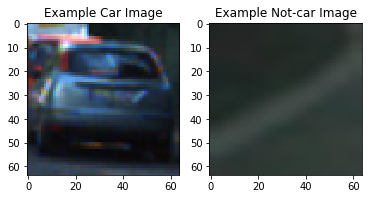

In [11]:
data_info = data_look(cars, notcars)

print('Your function returned a count of', 
      data_info["n_cars"], ' cars and', 
      data_info["n_notcars"], ' non-cars')
print('of size: ',data_info["image_shape"], ' and data type:', 
      data_info["data_type"])
# Just for fun choose random car / not-car indices and plot example images   
car_ind = np.random.randint(0, len(cars))
notcar_ind = np.random.randint(0, len(notcars))    
# Read in car / not-car images
car_image = mpimg.imread(cars[car_ind])
notcar_image = mpimg.imread(notcars[notcar_ind])


# Plot the examples
fig = plt.figure()
plt.subplot(121)
plt.imshow(car_image)
plt.title('Example Car Image')
plt.subplot(122)
plt.imshow(notcar_image)
plt.title('Example Not-car Image')

### Utilitys

In [12]:
import sys

# Print iterations progress
def print_progress(iteration, total):
    """
    Call in a loop to create terminal progress bar
    Parameters
    ----------
    iteration :
                Current iteration (Int)
    total     :
                Total iterations (Int)
    """
    str_format = "{0:.0f}"
    percents = str_format.format(100 * (iteration / float(total)))
    filled_length = int(round(100 * iteration / float(total)))
    bar = '█' * filled_length + '-' * (100 - filled_length)

    sys.stdout.write('\r |%s| %s%%' % (bar, percents)),

    if iteration == total:
        sys.stdout.write('\n')
    sys.stdout.flush()
    
# Define a function to return some characteristics of the dataset 
def data_look(car_list, notcar_list):
    data_dict = {}
    # Define a key in data_dict "n_cars" and store the number of car images
    data_dict["n_cars"] = len(car_list)
    # Define a key "n_notcars" and store the number of notcar images
    data_dict["n_notcars"] = len(notcar_list)
    # Read in a test image, either car or notcar
    example_img = mpimg.imread(car_list[0])
    # Define a key "image_shape" and store the test image shape 3-tuple
    data_dict["image_shape"] = example_img.shape
    # Define a key "data_type" and store the data type of the test image.
    data_dict["data_type"] = example_img.dtype
    # Return data_dict
    return data_dict

def plot_row4(img1, img2, img3, img4, label_1, label_2, label_3, label_4, graysc=True):
    # Plot the result (1 row with 4 images)
    f, (ax1, ax2, ax3, ax4) = plt.subplots(1, 4, figsize=(12, 4))
    f.tight_layout()
    if graysc:
        ax1.imshow(img1, cmap='gray')
    else:
        ax1.imshow(img1)
    ax1.set_title(label_1, fontsize=14)
    ax2.imshow(img2, cmap='gray')
    ax2.set_title(label_2, fontsize=14)
    ax3.imshow(img3, cmap='gray')
    ax3.set_title(label_3, fontsize=14)
    ax4.imshow(img4, cmap='gray')
    ax4.set_title(label_4, fontsize=14)
    plt.subplots_adjust(left=0., right=1, top=0.9, bottom=0.)
    
# Save data to pickle file
def saveTrainingDataIntoPickle(svc,X_scaler,orient,pix_per_cell,cell_per_block,spatial_size,hist_bins):
    dist_pickle = {}
    dist_pickle["svc"] = svc
    dist_pickle["scaler"] = X_scaler
    dist_pickle["orient"] = orient
    dist_pickle["pix_per_cell"] = pix_per_cell
    dist_pickle["cell_per_block"] = cell_per_block
    dist_pickle["spatial_size"] = spatial_size
    dist_pickle["hist_bins"] = hist_bins
    pickle.dump(dist_pickle, open("svc_pickle.p", 'wb') )
    
    print('Classifier parameters were saved to file')
    

def loadTrainingDataFromPickle():
    dist_pickle = pickle.load( open("svc_pickle.p", "rb" ) )
    svc = dist_pickle["svc"]
    X_scaler = dist_pickle["scaler"]
    orient = dist_pickle["orient"]
    pix_per_cell = dist_pickle["pix_per_cell"]
    cell_per_block = dist_pickle["cell_per_block"]
    spatial_size = dist_pickle["spatial_size"]
    hist_bins = dist_pickle["hist_bins"]
    
    print('Loading is done')


## Functions for feature extraction

In [13]:
from skimage.feature import hog
# Define a function to return HOG features and visualization


def convert_color(img, conv='RGB2YCrCb'):
    if conv == 'RGB2YCrCb':
        return cv2.cvtColor(img, cv2.COLOR_RGB2YCrCb)
    if conv == 'BGR2YCrCb':
        return cv2.cvtColor(img, cv2.COLOR_BGR2YCrCb)
    if conv == 'RGB2LUV':
        return cv2.cvtColor(img, cv2.COLOR_RGB2LUV)

def get_hog_features(img, orient, pix_per_cell, cell_per_block, 
                        vis=False, feature_vec=True):
    # Call with two outputs if vis==True
    if vis == True:
        features, hog_image = hog(img, orientations=orient, 
                                  pixels_per_cell=(pix_per_cell, pix_per_cell),
                                  cells_per_block=(cell_per_block, cell_per_block), 
                                  transform_sqrt=False, 
                                  visualise=vis, feature_vector=feature_vec)
        return features, hog_image
    # Otherwise call with one output
    else:      
        features = hog(img, orientations=orient, 
                       pixels_per_cell=(pix_per_cell, pix_per_cell),
                       cells_per_block=(cell_per_block, cell_per_block), 
                       transform_sqrt=False, 
                       visualise=vis, feature_vector=feature_vec)
        return features

def bin_spatial(img, size=(32, 32)):
    color1 = cv2.resize(img[:,:,0], size).ravel()
    color2 = cv2.resize(img[:,:,1], size).ravel()
    color3 = cv2.resize(img[:,:,2], size).ravel()
    return np.hstack((color1, color2, color3))

def color_hist(img, nbins=32):    #bins_range=(0, 256)
    # Compute the histogram of the color channels separately
    channel1_hist = np.histogram(img[:,:,0], bins=nbins)
    channel2_hist = np.histogram(img[:,:,1], bins=nbins)
    channel3_hist = np.histogram(img[:,:,2], bins=nbins)
    # Concatenate the histograms into a single feature vector
    hist_features = np.concatenate((channel1_hist[0], channel2_hist[0], channel3_hist[0]))
    # Return the individual histograms, bin_centers and feature vector
    return hist_features

# Define a function to extract features from a list of images
# Have this function call bin_spatial() and color_hist()
def extract_features(imgs, color_space='RGB', spatial_size=(32, 32),
                     hist_bins=32, orient=9, 
                     pix_per_cell=8, cell_per_block=2, hog_channel=0,
                     spatial_feat=True, hist_feat=True, hog_feat=True):
    # Create a list to append feature vectors to
    features = []
    # Iterate through the list of images
    for file in imgs:
        file_features = []
        # Read in each one by one
        image = mpimg.imread(file)
        # apply color conversion if other than 'RGB'
        if color_space != 'RGB':
            if color_space == 'HSV':
                feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2HSV)
            elif color_space == 'LUV':
                feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2LUV)
            elif color_space == 'HLS':
                feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2HLS)
            elif color_space == 'YUV':
                feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2YUV)
            elif color_space == 'YCrCb':
                feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2YCrCb)
        else: feature_image = np.copy(image)      

        if spatial_feat == True:
            spatial_features = bin_spatial(feature_image, size=spatial_size)
            file_features.append(spatial_features)
        if hist_feat == True:
            # Apply color_hist()
            hist_features = color_hist(feature_image, nbins=hist_bins)
            file_features.append(hist_features)
        if hog_feat == True:
        # Call get_hog_features() with vis=False, feature_vec=True
            if hog_channel == 'ALL':
                hog_features = []
                for channel in range(feature_image.shape[2]):
                    hog_features.append(get_hog_features(feature_image[:,:,channel], 
                                        orient, pix_per_cell, cell_per_block, 
                                        vis=False, feature_vec=True))
                hog_features = np.ravel(hog_features)        
            else:
                hog_features = get_hog_features(feature_image[:,:,hog_channel], orient, 
                            pix_per_cell, cell_per_block, vis=True, feature_vec=True)
            # Append the new feature vector to the features list
            file_features.append(hog_features)
            
        features.append(np.concatenate(file_features))
    # Return list of feature vectors
    return features

## Define paarmeter for feature extraction and a better handling

In [ ]:
## Tweak these parameters
#color_space    = 'YCrCb'    # Can be RGB, HSV, LUV, HLS, YUV, YCrCb
#orient         = 9          # HOG orientations
#pix_per_cell   = 8          # HOG pixels per cell
#cell_per_block = 2          # HOG cells per block
#hog_channel    = 'ALL'      # Can be 0, 1, 2, or "ALL"
#spatial_size   = (32, 32)   # Spatial binning dimensions
#hist_bins      = 32         # Number of histogram bins
#spatial_feat   = True       # Spatial features on or off
#hist_feat      = True       # Histogram features on or off
#hog_feat       = True       # HOG features on or off

## Classifier training pipeline

In [14]:
import numpy as np
from sklearn.grid_search import GridSearchCV
from sklearn import datasets, svm
import matplotlib.pyplot as plt
from sklearn.svm import LinearSVC
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from scipy.ndimage.measurements import label
%matplotlib inline

In [16]:
# Tweak these parameters
color_space    = 'YCrCb'    # Can be RGB, HSV, LUV, HLS, YUV, YCrCb
orient         = 9          # HOG orientations
pix_per_cell   = 16          # HOG pixels per cell
cell_per_block = 2          # HOG cells per block
hog_channel    = 'ALL'      # Can be 0, 1, 2, or "ALL"
spatial_size   = (16, 16)   # Spatial binning dimensions
hist_bins      = 8         # Number of histogram bins
spatial_feat   = True       # Spatial features on or off
hist_feat      = True       # Histogram features on or off
hog_feat       = True       # HOG features on or off
# class CAR feature extraction
t=time.time()

car_features = extract_features(cars, color_space=color_space, 
                                spatial_size=spatial_size, hist_bins=hist_bins, 
                                orient=orient, pix_per_cell=pix_per_cell, 
                                cell_per_block=cell_per_block, 
                                hog_channel=hog_channel, spatial_feat=spatial_feat, 
                                hist_feat=hist_feat, hog_feat=hog_feat)
t2 = time.time()
print(round(t2-t, 5), 'Seconds to CARS feature extraction')
print('CARS feature extraction done')

# class NONCAR feature extraction
t=time.time()
notcar_features = extract_features(notcars, color_space=color_space, 
                                spatial_size=spatial_size, hist_bins=hist_bins, 
                                orient=orient, pix_per_cell=pix_per_cell, 
                                cell_per_block=cell_per_block, 
                                hog_channel=hog_channel, spatial_feat=spatial_feat, 
                                hist_feat=hist_feat, hog_feat=hog_feat)
t2 = time.time()
print(round(t2-t, 5), 'Seconds to NONCARS feature extraction')
print('NONCARS feature extraction done')



24.91686 Seconds to CARS feature extraction
CARS feature extraction done
22.61894 Seconds to NONCARS feature extraction
NONCARS feature extraction done


In [ ]:
##### Normalize randomize, create feature vecto and split the data into train and test set ##########
# Create an array stack of feature vectors
X = np.vstack((car_features, notcar_features)).astype(np.float64)                        
# Fit a per-column scaler
X_scaler = StandardScaler().fit(X)
# Apply the scaler to X
scaled_X = X_scaler.transform(X)

# Define the labels vector
y = np.hstack((np.ones(len(car_features)), np.zeros(len(notcar_features))))


# Split up data into randomized training and test sets
rand_state = np.random.randint(0, 100)
X_train, X_test, y_train, y_test = train_test_split(
    scaled_X, y, test_size=0.2, random_state=rand_state)

print('Using spatial binning of:',spatial_size,
    'and', hist_bins,'histogram bins')
print('Feature vector length:', len(X_train[0]))

In [ ]:
# Cross validation with sklearn and GridSearchCV()
##################################
#parameter_candidates = [
#  {'C': [1, 10, 100, 1000], 'kernel': ['linear']},
#  {'C': [1, 10, 100, 1000], 'gamma': [0.001, 0.0001], 'kernel': ['rbf']},
#]
parameters = {'kernel':('linear', 'rbf'), 'C':[1, 10]}
print('parameter setting done. Now before GridSearchCV(...)')
# Create a classifier object with the classifier and parameter candidates
clf = GridSearchCV(estimator=svm.SVC(), param_grid=parameter_candidates, n_jobs=-1)
print('GridSearchCV done. Now before fit()')
t=time.time()
# Train the classifier on data1's feature and target data
clf.fit(X_train, y_train)
print('svc.fit(X_train, y_train) Now before getting best parameters')

t2 = time.time()

# View the best parameters for the model found using grid search
print('Best C:',clf.best_estimator_.C)
print('Best Kernel:',clf.best_estimator_.kernel)
print('Best Gamma:',clf.best_estimator_.gamma)
##################################

In [ ]:
##### Training of the classifier ##########
# Use a linear SVC 
svc = LinearSVC()
# Check the training time for the SVC
t=time.time()
svc.fit(X_train, y_train)
t2 = time.time()
print(round(t2-t, 2), 'Seconds to train SVC...')
# Check the score of the SVC
print('Test Accuracy of SVC = ', round(svc.score(X_test, y_test), 4))
# Check the prediction time for a single sample
t=time.time()
n_predict = 10
print('My SVC predicts: ', svc.predict(X_test[0:n_predict]))
print('For these',n_predict, 'labels: ', y_test[0:n_predict])

t2 = time.time()
print(round(t2-t, 5), 'Seconds to predict', n_predict,'labels with SVC')


In [ ]:
saveTrainingDataIntoPickle(svc,X_scaler,orient,pix_per_cell,cell_per_block,spatial_size,hist_bins)
print('Classifier parameters were saved to file')


## Pipeline

In [ ]:

    
out_img = find_cars(img, ystart, ystop, scale, svc, X_scaler, orient, pix_per_cell, cell_per_block, spatial_size, hist_bins)

## Multidetection and false positives

In [ ]:
from scipy.ndimage.measurements import label

def add_heat(heatmap, bbox_list):
    # Iterate through list of bboxes
    for box in bbox_list:
        # Add += 1 for all pixels inside each bbox
        # Assuming each "box" takes the form ((x1, y1), (x2, y2))
        heatmap[box[0][1]:box[1][1], box[0][0]:box[1][0]] += 1

    # Return updated heatmap
    return heatmap# Iterate through list of bboxes
    
def apply_threshold(heatmap, threshold):
    # Zero out pixels below the threshold
    heatmap[heatmap <= threshold] = 0
    # Return thresholded map
    return heatmap

def draw_labeled_bboxes(img, labels):
    # Iterate through all detected cars
    for car_number in range(1, labels[1]+1):
        # Find pixels with each car_number label value
        nonzero = (labels[0] == car_number).nonzero()
        # Identify x and y values of those pixels
        nonzeroy = np.array(nonzero[0])
        nonzerox = np.array(nonzero[1])
        # Define a bounding box based on min/max x and y
        bbox = ((np.min(nonzerox), np.min(nonzeroy)), (np.max(nonzerox), np.max(nonzeroy)))
        # Draw the box on the image
        cv2.rectangle(img, bbox[0], bbox[1], (0,0,255), 6)
    # Return the image
    return img


In [ ]:
loadTrainingDataFromPickle() 

In [ ]:
def find_cars(img, svc, X_scaler, orient, pix_per_cell, cell_per_block, 
              spatial_size, hist_bins):
    draw_img = np.copy(img)
    img = img.astype(np.float32)/255
    
    # prepare multiScaling
    ystart_ystop_scale = [(380, 480, 1), (400, 600, 1.5), (500, 700, 2.5)]
    win_pos = []
    
    for (ystart, ystop, scale) in ystart_ystop_scale:
        img_tosearch = img[ystart:ystop, :, :]
        ctrans_tosearch = convert_color(img_tosearch, conv='RGB2YCrCb')
        
        if scale != 1:
            imshape = ctrans_tosearch.shape
            ctrans_tosearch = cv2.resize(ctrans_tosearch, (np.int(imshape[1]/scale), np.int(imshape[0]/scale)))
        
        ch1 = ctrans_tosearch[:,:,0]
        ch2 = ctrans_tosearch[:,:,1]
        ch3 = ctrans_tosearch[:,:,2]

        # Define blocks and steps as above
        nxblocks = ((ch1.shape[1] // pix_per_cell) - cell_per_block + 1)
        nyblocks = ((ch1.shape[0] // pix_per_cell) - cell_per_block + 1)
        nfeat_per_block = orient * cell_per_block**2
    
        # 64 was the orginal sampling rate, with 8 cells and 8 pix per cell
        window = 8*8
        nblocks_per_window = (window // pix_per_cell) - cell_per_block + 1
        cells_per_step = 2  # Instead of overlap, define how many cells to step
        nxsteps = (nxblocks - nblocks_per_window) // cells_per_step
        nysteps = (nyblocks - nblocks_per_window) // cells_per_step
    
        # Compute individual channel HOG features for the entire image
        hog1 = get_hog_features(ch1, orient, pix_per_cell, cell_per_block, feature_vec=False)
        hog2 = get_hog_features(ch2, orient, pix_per_cell, cell_per_block, feature_vec=False)
        hog3 = get_hog_features(ch3, orient, pix_per_cell, cell_per_block, feature_vec=False)
    

        for xb in range(nxsteps + 1):
            for yb in range(nysteps + 1):
                ypos = yb * cells_per_step
                xpos = xb * cells_per_step
                # Extract HOG for this patch
                hog_feat1 = hog1[ypos:ypos+nblocks_per_window, xpos:xpos + nblocks_per_window].ravel() 
                hog_feat2 = hog2[ypos:ypos+nblocks_per_window, xpos:xpos + nblocks_per_window].ravel() 
                hog_feat3 = hog3[ypos:ypos+nblocks_per_window, xpos:xpos + nblocks_per_window].ravel() 
                hog_features = np.hstack((hog_feat1, hog_feat2, hog_feat3))

                xleft = xpos * pix_per_cell
                ytop = ypos * pix_per_cell

                # Extract the image patch
                subimg = cv2.resize(ctrans_tosearch[ytop:ytop + window, xleft:xleft + window], (64, 64))
          
                # Get color features
                spatial_features = bin_spatial(subimg, size=spatial_size)
                hist_features = color_hist(subimg, nbins=hist_bins)

                # Scale features and make a prediction
                test_features = X_scaler.transform(np.hstack((spatial_features, hist_features, hog_features)).reshape(1, -1))    
                test_prediction = svc.predict(test_features)
            
                # If detected
                if test_prediction == 1:
                    xbox_left = np.int(xleft * scale)
                    ytop_draw = np.int(ytop * scale)
                    win_draw = np.int(window * scale)
                    cv2.rectangle(draw_img, (xbox_left, ytop_draw + ystart), 
                                  (xbox_left + win_draw, ytop_draw + win_draw + ystart), (0,0,255), 2)
                    win_pos.append(((xbox_left, ytop_draw + ystart), 
                                    (xbox_left + win_draw, ytop_draw + win_draw + ystart)))
    return draw_img, win_pos